In [ ]:
!pip install transformers==4.28.0
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchaudio
root = './'
train_dataset = torchaudio.datasets.LIBRISPEECH(root, url='train-clean-100', download=True)

100%|██████████| 5.95G/5.95G [04:08<00:00, 25.7MB/s]


In [ ]:
from torch.utils.data import random_split
lengths = [int(len(train_dataset)*0.8),
           int(len(train_dataset)*0.1),
           len(train_dataset) - int(len(train_dataset)*0.8)-int(len(train_dataset)*0.1)]
train_dataset, val_dataset, test_dataset = random_split(train_dataset, lengths)

In [ ]:
#Downloading Hubert Model for ASR
from transformers import HubertForCTC
hubert=HubertForCTC.from_pretrained('facebook/hubert-large-ls960-ft')

In [ ]:
from transformers import AutoProcessor, HubertModel
processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")

In [ ]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained('gpt2')

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import AutoFeatureExtractor
whisper_ckpt='openai/whisper-base'
feature_extractor=AutoFeatureExtractor.from_pretrained(whisper_ckpt)

In [ ]:
import numpy as np
#Dataset class for the model
#Audio truncated upto 10 seconds
#returns audio features, labels and the respective prompt along with text transcription
class dataset(Dataset):
  def __init__(self,train_df,feature_extractor,tokenizer,processor,asr_generator):
    super().__init__()
    self.train_df=train_df
    self.feature_extractor=feature_extractor
    self.tokenizer=tokenizer
    self.processor=processor
    self.asr_generator=asr_generator.to(device)
  def __len__(self):
    return len(self.train_df)
  def __getitem__(self,idx):
    waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id=self.train_df[idx]
    waveform=waveform[0]
    min_len=min(len(waveform),sample_rate*10)
    audio_feat=torch.zeros((min_len))
    waveform=torch.tensor(waveform)
    audio_feat[:min_len]=waveform[:min_len].clone().detach()

    #1 Audio features extractracted from Whisper Feature extractor
    audio_feats=self.feature_extractor(audio_feat,sampling_rate=sample_rate,return_tensors='pt')['input_features']

    #2 Labels processed using gpt2 tokenizer
    labels_batch=self.tokenizer(utterance,return_tensors='pt',max_length=200,padding='max_length',truncation=True)
    sum=torch.sum(labels_batch.attention_mask,axis=-1)
    labels_batch.attention_mask[:,sum]=1
    labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

    #3 Text produced using Hubert

    processed=self.processor(audio_feat,sampling_rate=sample_rate,return_tensors='pt')['input_values'].to(device)
    asr_text=self.asr_generator.forward(processed).logits.cpu()
    asr_text=torch.argmax(asr_text,dim=-1)
    asr=self.processor.batch_decode(asr_text,skip_special_tokens=True)
    asr=self.tokenizer(asr,max_length=100,padding='max_length',truncation=True,return_tensors='pt')['input_ids']


    #4 Prompt for specific task
    prompt_ids=self.tokenizer(utterance,return_tensors='pt',max_length=200,padding='max_length',truncation=True)['input_ids']


    audio_feats=torch.squeeze(audio_feats,axis=0).to(device)
    labels=torch.squeeze(labels,axis=0).to(device)
    prompt_ids=torch.squeeze(prompt_ids,axis=0).to(device)
    asr=torch.squeeze(asr,axis=0).to(device)

    return audio_feats,labels,asr,prompt_ids

In [ ]:
tokenizer.pad_token=tokenizer.eos_token

In [ ]:
tr_dataset=dataset(train_dataset,feature_extractor,tokenizer,processor,hubert)
train_loader=DataLoader(tr_dataset,batch_size=4,shuffle=True)

In [ ]:
val_dataset=dataset(val_dataset,feature_extractor,tokenizer,processor,hubert)
test_dataset=dataset(test_dataset,feature_extractor,tokenizer,processor,hubert)

val_loader=DataLoader(val_dataset,batch_size=4,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=True)

In [ ]:
from transformers import AutoConfig
ckpt1='openai/whisper-base'
ckpt2='gpt2'

In [ ]:
from transformers import HubertForCTC
hubert_model=HubertForCTC.from_pretrained('facebook/hubert-large-ls960-ft')

In [ ]:
import torch.nn as nn
from transformers import AutoConfig
from transformers import GPT2LMHeadModel
from transformers import WhisperModel
#Transformer mapper network
"""Arguments- input-dimension, number of heads, hidden size dimension, number of blocks, input sequence length,
output_sequence length and output dimension.
Projects input to output dimension followed by multiheadself attention and sequence length reduction
"""
class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead, nhid, nlayers, inp_seq_len,out_seq, output_dim):
        super(TransformerModel, self).__init__()

        # Stage 1: Self-attention mechanism that changes the output dimension
        self.encoder = nn.Linear(input_dim, nhid)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(nhid, nhead), nlayers
        )
        self.proj = nn.Linear(nhid,output_dim)

        # Stage 2: Learned positional encoding to change the sequence length
        # self.pos_encoder = nn.Linear(inp_seq_len, out_seq)
        self.out_seq=out_seq


    def forward(self, src):
        src = self.encoder(src)
        src = self.transformer_encoder(src)
        src = self.proj(src)

        # Adjust the sequence length
        src = src[:,:self.out_seq,:]

        return src

"""
Main model consists of
whisper encoder, Mapper transformer, GPT2 Decoder
returns loss,logits
"""
class pengi_model_alike(nn.Module):
  def __init__(self,whisper_ckpt,gpt2_ckpt):
    super().__init__()
    self.whisper_encoder=WhisperModel.from_pretrained(whisper_ckpt).encoder
    self.whisper_ckpt=self.whisper_encoder.config
    self.gpt2=GPT2LMHeadModel.from_pretrained(gpt2_ckpt)
    self.gpt2_ckpt=self.gpt2.config
    self.mapping=TransformerModel(input_dim=self.whisper_ckpt.d_model,
                                      nhead=6,
                                     nhid=1440,
                                    nlayers=8,
                                    inp_seq_len=self.whisper_ckpt.max_source_positions,
                                     out_seq=500,
                                     output_dim=self.gpt2_ckpt.n_embd)


  def forward(self,
              input_audio_features,
              asr_text_ids=None,
              input_text_ids=None,
              input_text_embeds=None,
              labels=None,
              return_dict=False):

    out=self.whisper_encoder(input_audio_features)
    audio_embeddings=out[0]

    lab_dtype=labels.dtype
    audio_embeddings=self.mapping(audio_embeddings)


    out_seq=self.mapping.out_seq
    #label preparation
    inp_labels=-100*torch.ones((labels.shape[0],out_seq+asr_text_ids.shape[-1]))


    #input preparation
    input_embeds=torch.concat([audio_embeddings,self.gpt2.transformer.wte(asr_text_ids)],axis=-2)
    input_embeds=torch.concat([input_embeds,self.gpt2.transformer.wte(input_text_ids)],axis=-2)

    inp_labels=inp_labels.to(labels.device)

    labels=torch.concat([inp_labels.to(labels.device),labels],axis=-1)
    out=self.gpt2(inputs_embeds=input_embeds,labels=labels.to(lab_dtype),return_dict=return_dict)

    return out

In [ ]:
pengi=pengi_model_alike(ckpt1,ckpt2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
state_dict = torch.load('/content/drive/MyDrive/ALM_models2/Experiment.pt')
pengi.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
!pip install wandb
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=a809c0b6164077f8a871277346837b621887c6b1468c72673e4ce17dd518575b
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch.optim as optim
wandb.init(
    project='alm_model_run23_exp_asr',
)

wandb: Currently logged in as: devansh20053 (devansh2002). Use `wandb login --relogin` to force relogin


In [ ]:
def generate_text(input_embeddings, model, tokenizer, temperature=1.0, max_length=100, eos_token_id=None):
    # Assume input_embeddings is a tensor of shape [1, seq_len, hidden_size]
    past_key_values = None
    generated_tokens = []
    print(input_embeddings.shape)
    # Apply softmax to logits to get token probabilities
    softmax = torch.nn.functional.softmax
    for i in range(max_length):

        outputs = model.gpt2(inputs_embeds=input_embeddings,past_key_values=None)
        logits = outputs.logits
        past_key_values = outputs.past_key_values

        # Apply a temperature to the logits to control the randomness of the predictions
        scaled_logits = logits[:, -1, :] / temperature
        """
        For getting a multinomial distribution for sampling next token use the below code
        next_token = torch.multinomial(softmax(scaled_logits, dim=-1), num_samples=1)
        """
        next_token = torch.argmax(torch.softmax(scaled_logits, dim=-1), dim=-1).unsqueeze(-1)
        generated_tokens.append(next_token.item())
        next_embeds = model.gpt2.transformer.wte(next_token)
        input_embeddings=torch.concat([input_embeddings,next_embeds],axis=1)
        if eos_token_id is not None and next_token == eos_token_id:
            break

    # Convert the list of output tokens into a string
    output_text = tokenizer.decode(generated_tokens,skip_special_tokens=True)
    return output_text

In [ ]:
!pip install torchmetrics
from torchmetrics.functional import word_error_rate
#Evaluation function for calculating the wer rate
def calc_wer(model,tokenizer,audio,text,labels):
  audio_embedding=model.whisper_encoder(audio)[0]
  audio_embedding=model.mapping(audio_embedding)

  audio_embedding=torch.concat([audio_embedding,model.gpt2.transformer.wte(text)],axis=1)
  generated_text=generate_text(audio_embedding,model,tokenizer)

  arr=-100*torch.ones(labels.shape)
  mask=arr==labels.cpu()
  labels=labels.cpu()
  labels=labels.masked_fill(mask,50256)
  ground_truth=tokenizer.batch_decode(labels.cpu().detach(),skip_special_tokens=True)

  wer=word_error_rate(generated_text,ground_truth)
  wer=wer/labels.shape[0]
  #prints those samples showing relatively higher wer
  if(wer>0.35):
    print("Ground Truth")
    for gr in ground_truth:
      print(gr)
    print("Gemerated Text")
    for gen in generated_text:
      print(gen)

  return wer

In [ ]:
from tqdm import tqdm
def train(model,train_loader,val_loader,epochs,logging_steps,optim,scheduler,grad_acc=1,):
  gradient_accumulator = {}
  for name,param in model.named_parameters():
    gradient_accumulator[name]=0.0

  # Define the total number of training steps and create a scheduler
  total_steps = len(train_loader) * epochs

  #wandb.watch(model,log='all',log_freq=20)
  train_loss=[]
  val_loss=[]
  wer=[]
  tr_steps=0
  val_steps=0
  best_val_loss = float('inf')

  for ep in range(epochs):
    running_loss=0.0
    model.train()
    for i,(audio,labels,asr,prompt) in enumerate(tqdm(train_loader)):
      out=model(input_audio_features=audio.to(device),
              asr_text_ids=asr.to(device),
              input_text_ids=prompt.to(device),
              labels=labels.to(device))
      loss=out[0]
      running_loss+=loss.item()
      loss.backward()

      # Gradient accumulation
      for name, param in model.named_parameters():
        gradient_accumulator[name] += param.grad if param.grad is not None else 0.0

      if (i + 1) % grad_acc == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(running_loss/(i+1))  # Update learning rate schedule
        optimizer.zero_grad()

        for name, param in model.named_parameters():
          gradient_accumulator[name]=0

      if((i+1)%logging_steps==0):
        train_loss.append(running_loss/(i+1))
        tr_steps+=1
        wandb.log({"tr/loss":train_loss[-1],
                   "tr/step":tr_steps})

    if i % grad_acc != 0:
      optimizer.step()
      optimizer.zero_grad()

    model.eval()
    running_loss=0.0
    running_wer=0.0
    with torch.no_grad():
      for i,(audio,labels,asr,prompt) in enumerate(tqdm(val_loader)):
        out=model(input_audio_features=audio.to(device),
              asr_text_ids=asr.to(device),
              input_text_ids=prompt.to(device),
              labels=labels.to(device))
        loss=out[0]
        running_loss+=loss.item()
        running_wer+=calc_wer(model,tokenizer,audio,asr,labels)
        if((i+1)%logging_steps==0):
          val_loss.append(running_loss/(i+1))
          wer.append(running_wer/(i+1))
          val_steps+=1
          wandb.log({"val/loss":val_loss[-1],
                     "val/wer":wer[-1],
                     "val/step":val_steps})
  return train_loss,val_loss,wer


In [ ]:
for param in pengi.whisper_encoder.parameters():
  param.requires_grad=False

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Add weight decay into the optimizer
learning_rates=[
    {"params":pengi.mapping.parameters(),"lr":0.001,'weight_decay':0.01},
    {"params":pengi.gpt2.parameters(),"lr":0.00001,'weight_decay':0.01},
]
optimizer=optim.Adam(learning_rates)

# Define the total number of training steps and create a scheduler
total_steps = len(train_loader) * 2
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# from torch.optim.lr_scheduler import CyclicLR
# scheduler = CyclicLR(optimizer, base_lr=0.00001, max_lr=0.1, step_size_up=2000)
total_epochs = 2
warmup_steps = 2000
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_epochs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
pengi=pengi.to(device)
train(pengi.to(device),train_loader,val_loader,2,25,optimizer,scheduler,grad_acc=4)

100%|██████████| 714/714 [1:16:05<00:00,  6.39s/it]


([6.331889572143555,
  6.103113040924073,
  5.989053262074789,
  5.914097380638123,
  5.857558055877686,
  5.809285271962484,
  5.750496839795794,
  5.7066207075119015,
  5.6659862285190155,
  5.6331154670715335,
  5.588004646301269,
  5.5418385934829715,
  5.495917276235727,
  5.441327179500035,
  5.388919637044271,
  5.3409992182254795,
  5.296514650232652,
  5.258595768610636,
  5.214776776966295,
  5.177080828666687,
  5.14624176297869,
  5.112152299880981,
  5.080694876131804,
  5.050759199460347,
  5.0235694366455075,
  4.994922925875737,
  4.969834047600075,
  4.944628457682473,
  4.921146328038183,
  4.896471722920736,
  4.8725938190952425,
  4.845286103188991,
  4.814997239835335,
  4.775313313708586,
  4.731698767798288,
  4.681796075238122,
  4.630220280466853,
  4.5752322033831945,
  4.520839165418576,
  4.466113911747932,
  4.414169790454027,
  4.361539046764374,
  4.312583809786065,
  4.263057491237467,
  4.215078815778097,
  4.168467777190001,
  4.123822401330826,
  4.07

In [ ]:
from tqdm import tqdm
def predict(model,test_loader):
  wer=[]
  list_loss=[]
  running_loss=0.0
  running_wer=0.0
  model.eval()
  with torch.no_grad():
    for i,(audio,labels,asr,prompt) in enumerate(tqdm(test_loader)):
      if((i+1)%100==0):
        break
      out=model(input_audio_features=audio.to(device),
            asr_text_ids=asr.to(device),
            input_text_ids=prompt.to(device),
            labels=labels.to(device))
      loss=out[0]
      curr_loss=loss.item()
      curr_wer=calc_wer(model,tokenizer,audio,asr,labels)
      wer.append(curr_wer)
      list_loss.append(curr_loss)
  return loss,wer

In [ ]:
pengi=pengi.to(device)

In [ ]:
loss,wer=predict(pengi,test_loader)

  0%|          | 0/714 [00:00<?, ?it/s]<ipython-input-10-4fb95c0ef9d0>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform=torch.tensor(waveform)
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:69: FutureWarning: Importing `word_error_rate` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `word_error_rate` from `torchmetrics.text` instead.
  _future_warning(
  3%|▎         | 23/714 [02:27<1:13:29,  6.38s/it]

Ground Truth
AND ON PERCEIVING WHOM SHE SAID TO THE GIRLS
OR WHICH THEY REGARDED AS SOME SET OFF AGAINST THEIR SWOLLEN ACCOUNT OF CRUEL RAGE NO MAN CAN DECIDE NOW TO WHICH OF THESE MOTIVES SUCH EXTRAORDINARY SCENES WERE REFERABLE IT IS PROBABLE TO A BLENDING OF ALL THE THREE
SHE FLEW AT LAGREE'S FACE AND TORE OUT HER ONLY EYE THUS DELIVERING THE PRINCESS FOR EVER FROM HER PERSECUTOR
SHE WAS ABOUT TEN YEARS OLD AND TAKEN FROM THE DOOR AT FIRST BY A PRAYING INDIANA AND AFTERWARD SOLD FOR A GUN
Gemerated Text
AND ON PERCEIVING WHOM SHE SAID TO THE GIRLS
AND ON PERCEIVING WHOM SHE SAID TO THE GIRLS
AND ON PERCEIVING WHOM SHE SAID TO THE GIRLS
AND ON PERCEIVING WHOM SHE SAID TO THE GIRLS
AND ON PERCEIVING WHOM SHE SAID TO THE GIRLSAND ON PERCEIVING WHOM SHE SA
OR WHICH THEY REGARDED AS SOME SET OF AGAINST THEIR SWOLEN ACOUNT OF CRUEL RAGE NO MAN CAN DECIDE NOW TO WHICH OF THESE MOTIVES SUCH EXTRAORDINARY

OR WHICH THEY REGARDED AS SOME SET OF AGAINST THEIR SWOLEN ACOUNT OF CRUEL RAGE NO MAN

  6%|▌         | 42/714 [04:29<1:12:00,  6.43s/it]

Ground Truth
THE QUESTION I AM GOING TO PUT TO YOU MUST IN THESE SAD CIRCUMSTANCES BE A PAINFUL ONE
HAS HAD AN EXTRA STOUT BONE SHAKER MADE TO ORDER
RUSSEN AND FAIR PULLING LYON RILEY CHESHIRE AND LESLY WITH MUSKETS AND JOHN REX IN THE STERN SHEETS
AND ENGAGED THE OWNER TO SEND A MAN AROUND AT ONCE TO THE HOME OF THE MISER SO AS TO REPLACE A TWELVE BY TWENTY PANE OF GLASS I EXPECT TO HAVE A GOOD MANY ORDERS LIKE THAT FRANK BEFORE THE DAY IS OVER REMARKED THE DEALER LAUGHINGLY
Gemerated Text
THE QUESTION I AM GOING TO PUT TO YOU MUST IN THESE SAD CIRCUMSTANCES BE A PAINFUL ONE
THE QUESTION I AM GOING TO PUT TO YOU MUST IN THESE SAD CIRCUMSTANCES BE A PAINFUL ONE
THE QUESTION I AM GOING TO PUT TO YOU MUST IN THESE SAD CIRCUMSTANCES BE A PAINFUL ONEThe question is: How do you
"HAS HAD AN EXTRA STOUT BONE SHAKER MADE TO ORDER

TO ORDER

TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO ORDER
TO

 10%|▉         | 68/714 [07:16<1:08:50,  6.39s/it]

Ground Truth
BLOT SAW A LITTLE KITTEN MEWING PITIFULLY AS IT SAT UNDER THE FENCE WHAT IS THE MATTER DEAR ASKED KIND BLOT
THE KING ROSE IN HIS STIRRUPS AND MADE A LOW OBEISANCE TO THE WINDOW WHERE THEY WERE STANDING WE SHALL HAVE SOME COURT BEAUTIES BEVERLEY SAID THE KING LOOKING AT HIM OVER HIS SHOULDER AS SOON AS THE CEREMONIES WERE OVER
YOU CAN START AT ONCE BUT IF YOU WAIT UNTIL TO MORROW WHEN I CAN SPARE THE MEN YOU CAN BE CARRIED ALL THE WAY
THE MEN OF THE REVOLUTION ARE SO GREAT THAT THEY HAVE THE PRESTIGE OF THE AGES LIKE CATO
Gemerated Text
BLOT SAW A LITLE KITEN MEWING PITIFULY AS IT SAT UNDER THE FENCE WHAT IS THE MATER DEAR ASKED KIND BLOT
BLOT SAW A LITLE KITEN MEWING PITIFULY AS IT SAT UNDER THE FENCE WHAT IS THE MATER DEAR ASKED KIND BLOTBLOT SAW A LITLE KITEN MEWING PITIFULY AS
THE KING ROSE IN HIS STIRUPS AND MADE A LOW OBEISANCE TO THE WINDOW WHERE THEY WERE STANDING WE SHAL HAVE SOME COURT BEAUTIES BEVERLY SAID THTHE KING ROSE IN HIS STIRUPS AND MADE A LOW OBEISANCE T

 10%|▉         | 71/714 [07:35<1:08:56,  6.43s/it]

Ground Truth
YESTERDAY I SENT A SERJEANT AT ARMS TO DEMAND SOME WHO BY MY ORDER WERE ACCUSED OF HIGH TREASON INSTEAD OF OBEDIENCE I RECEIVED A MESSAGE I MUST HERE DECLARE TO YOU
AND THE MARSHALL FIELD MUSEUM OF CHICAGO AS WELL AS OTHER INSTITUTIONS IT WAS THE CHICAGO MUSEUM WHICH SENT HIM TO THE PHILIPPINE ISLANDS WHERE HE WAS MURDERED BY THE NATIVES A FEW YEARS AGO
MAY TEN EIGHTEEN FIFTY ONE MADAME
AND REMAINED SHUT IN THERE ANNIE WAS UNEASILY AWARE OF HIM FROM TIME TO TIME BUT LYRA HAD APPARENTLY NO MORE DISTURBANCE FROM HIS ABSENCE THAN FROM HIS PRESENCE WHICH SHE HAD MANAGED WITH A FRANK ACCEPTANCE OF EVERYTHING IT SUGGESTED
Gemerated Text
YESTERDAY I SENT A SERGEANT AT ARMS TO DEMAND SOME WHO BY MY ORDER WERE ACUSED OF HIGH TREASON INSTEAD OF OBEDIENCENO MORE SHALL I SENT A SERGEANT AT ARMS TO DEMAND SOME WHO BY MY ORDER WERE ACUSED OF HIGH TREASON INSTEAD OF OBEDIENCENO MORE SHALL I SENT A SERGEANT AT ARMS TO DEMAND SOME WHO BY MY ORDER WERE
AND THE MARSHAL FIELD MUSEUM OF CHICAG

 12%|█▏        | 89/714 [09:31<1:07:02,  6.44s/it]

Ground Truth
THE BEAUTIFUL PRAYERS OF THE CHURCH HAD GONE DOWN WITH THE DEPARTING SOUL TO THE THRESHOLD OF THE NEW LIFE AND HAD FOLLOWED IT INTO ETERNITY SHE SEEMED CLOSE TO THEM STILL IN THE LIGHT OF THAT WONDERFUL NEW FAITH
SAINT BRIDE'S ZERO SAINT JAMES'S EIGHT
IS FAMOUS FOR ITS PEARL FISHERIES WOULD YOU BE INTERESTED PROFESSOR ARONNAX
NEXT TO ME MY TWO COMPANIONS WERE GETTING TIPSY ON THE FRESH OXYGEN PARTICLES POOR SOULS WHO HAVE SUFFERED FROM LONG STARVATION MUSTN'T POUNCE HEEDLESSLY ON THE FIRST FOOD GIVEN THEM WE ON THE OTHER HAND DIDN'T HAVE TO PRACTICE SUCH MODERATION
Gemerated Text
THE BEAUTIFUL PRAYERS OF THE CHURCH HAD GONE DOWN WITH THE DEPARTING SOUL TO THE THRESHOLD OF THE NEW LIFE AND HAD FOLOWED IT INTO ETERNITY STHE BEAUTIFUL PRAYERS OF THE CHURCH HAD GONE DOWN WITH THE DEPARTING SOUL TO THE THRESHOLD OF THE NEW LIFE AND HAD FOLOWED IT INTO ETERNITY STHE
SAINT BRIDE'S ZERO SAINT JAMES'S EIGHT

TO SEE THE WORLD
SAINT BRIDE'S ZERO SAINT JAMES'S EIGHT
TO SEE THE WORLD
S

 13%|█▎        | 92/714 [09:50<1:06:53,  6.45s/it]

Ground Truth
THE THIEVES HAD ALREADY APPROACHED ANDREA SOME SCREAMING
NO IT DON'T NOT A MITE PERHAPS DIZZY ISN'T JUST THE RIGHT WORD BUT IT'S NEAREST I'D LIKE TO EAT COLOR AND DRINK IT AND SLEEP IN IT IF YOU COULD BE A TREE WHICH ONE WOULD YOU CHOOSE
WHO PLAYED LIKE BOYS AND CUT UP ALL SORTS OF CAPERS A MAMMA SAT TENDING HER BABY AND LOOKING SO LIKE A LITTLE OLD WOMAN THAT I LAUGHED TILL THE GRAY MONKEY WITH THE BLUE NOSE SCOLDED AT ME
MY NAME IS HOUARN HE ANSWERED
Gemerated Text
THE THIEVES HAD ALREADY APROACHED ANDREA SOME SCREAMING
TOO MUCH

TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH
TOO MUCH

TOO MUCH

TOO MUCH

TOO
NO IT DON'T A MITE PERHAPS DIZY ISN'T JUST THE RIGHT WORD BUT IT'S NEAREST I'D LIKE TO EAT COLOR AND DRINK INO IT DON'T A MITE PERHAPS DIZY ISN'T JUST THE RIGHT WORD BUT IT'S NEAREST I'D LIKE TO EAT COLOR AND DRINK ITHE LORD GODS SHALL BE WITH ME AND ALL SHALL
WHO PLAYED LIKE BOYS AND CUT UP AL SORTS OF CAPERS A MA

 13%|█▎        | 93/714 [09:57<1:06:35,  6.43s/it]

Ground Truth
TO WHAT PURPOSE SEPARATE THE EXECUTIVE OR THE JUDICIARY FROM THE LEGISLATIVE IF BOTH THE EXECUTIVE AND THE JUDICIARY ARE SO CONSTITUTED AS TO BE AT THE ABSOLUTE DEVOTION OF THE LEGISLATIVE SUCH A SEPARATION MUST BE MERELY NOMINAL
LOOK HERE SAID HE TURNING ROUND TO THE MINER YOUR MEDICINE WILL BE MADE UP IN ITS TURN AND SENT DOWN TO YOU I DON'T ALLOW FOLK IN THE SURGERY WAIT OUTSIDE IN THE WAITING ROOM IF YOU WISH TO WAIT AT ALL YOONG MAN SAID THE MINER
OR RATHER THE GRIM TRANQUILLITY OF AWFUL EXPECTATION BUT NOW THE WAR DRUM RUMBLES FROM AFAR THE BRAZEN TRUMPET BRAYS ITS THRILLING NOTE
AND DUTY WITH GENTLENESS AND HE REWARDED THEM
Gemerated Text
TO WHAT PURPOSE SEPARATE THE EXECUTIVE OR THE JUDICIARY FROM THE LEGISLATIVE IF BOTH THE EXECUTIVE AND THE JUDICIARY ARE SO CONSTITUTED AS TO BE AT THE ABSOLUTETO WHAT PURPOSE SEPARATE THE EXECUTIVE OR THE JUDICIARY FROM THE LEGISLATIVE IF BOTH THE EXECUTIVE AND THE JUDICIARY ARE SO CONST
LOK HERE SAID HE TURNING ROUND TO THE MINER

 14%|█▍        | 99/714 [10:36<1:05:51,  6.42s/it]


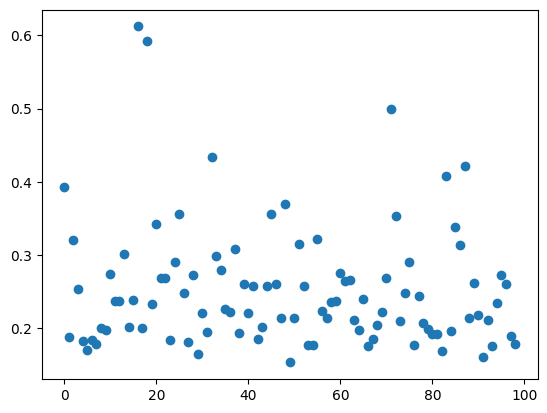

In [ ]:
import matplotlib.pyplot as plt
plt.scatter([i for i in range(len(wer))],wer)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/ALM_models2/Experiment.pt'
torch.save(pengi.state_dict(), file_path)